<a href="https://colab.research.google.com/github/HANKSOONG/image-repair-and-restoration-/blob/main/Benjamini_Hochberg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Code Part

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# using BH method with cross-validation (one vs others)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# import data
golub_data = pd.read_csv('/content/drive/MyDrive/bhmethods/golub.csv')

# Extracting gene expression data
gene_expression = golub_data.iloc[:, 6:]  # The 7th column starts with gene
group_labels = golub_data['cancer'].values


### Analyzing allB vs others ###

### Analyzing aml vs others ###

### Analyzing allT vs others ###
            Group  BH significant genes  \
0            allB                   719   
1             aml                   992   
2            allT                   290   
3  cross-category                    66   

                                 Top 10 Marker Genes  
0  M89957_at, M84371_rna1_s_at, U05259_rna1_at, Y...  
1  Y08612_at, M31211_s_at, M31523_at, X59417_at, ...  
2  X62744_at, X03100_cds2_at, M57466_s_at, HG688-...  
3  J05257_at, X17093_at, U36922_at, M63959_at, M9...  
Cross-category and specific significant genes saved successfully.


In [ ]:

# define cross-validation scenarios
groups = ['allB', 'aml', 'allT']

summary_results = []
significant_genes_dict = {}

for target_group in groups:
    print(f"\n### Analyzing {target_group} vs others ###")
    group1_expr = gene_expression[group_labels == target_group]
    group2_expr = gene_expression[group_labels != target_group]

    # Calculate p-value
    p_values = np.array([
        ttest_ind(group1_expr.iloc[:, i], group2_expr.iloc[:, i], equal_var=False).pvalue
        for i in range(gene_expression.shape[1])
    ])

    # BH method
    reject_bh, pvals_corrected_bh, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Plot raw p-value distribution
    plt.figure(figsize=(8, 4))
    plt.hist(p_values, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Raw P-value Distribution ({target_group} vs others)')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.savefig(f'/content/drive/MyDrive/bhmethods/Untitled Folder/raw_p_distribution_{target_group}.png')
    plt.close()

    # Plot BH corrected p-value distribution
    plt.figure(figsize=(8, 4))
    plt.hist(pvals_corrected_bh, bins=50, color='lightgreen', edgecolor='black')
    plt.title(f'BH Corrected P-value Distribution ({target_group} vs others)')
    plt.xlabel('Adjusted P-value')
    plt.ylabel('Frequency')
    plt.savefig(f'/content/drive/MyDrive/bhmethods/Untitled Folder/bh_p_distribution_{target_group}.png')
    plt.close()

    # BH threshold plot
    sorted_pvals = np.sort(p_values)
    ranks = np.arange(1, len(sorted_pvals) + 1)
    bh_threshold = ranks / len(sorted_pvals) * 0.05
    k = np.max(np.where(sorted_pvals <= bh_threshold)[0]) + 1

    plt.figure(figsize=(8, 6))
    plt.scatter(ranks, sorted_pvals, color='black', s=10)
    plt.plot(ranks, bh_threshold, color='red', linewidth=1)
    plt.axvline(x=k, linestyle='--', color='gray', label=f'k = {k}')
    plt.title(f'BH Threshold Plot ({target_group} vs others)')
    plt.xlabel('Rank')
    plt.ylabel('P-value')
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/bhmethods/Untitled Folder/bh_threshold_plot_{target_group}.png')
    plt.close()

    # Summarize the results
    results_df = pd.DataFrame({
        "Gene": gene_expression.columns,
        "Raw p-value": p_values,
        "BH Adjusted p-value": pvals_corrected_bh,
        "Significant (BH)": reject_bh
    })

    results_df = results_df.sort_values("Raw p-value")

    # Top 10 marker genes
    top_10_genes = results_df.head(10)['Gene'].tolist()
    significant_genes_dict[target_group] = set(results_df[results_df['Significant (BH)']]['Gene'])

    # save results
    file_path = f'/content/drive/MyDrive/bhmethods/Untitled Folder/golub_analysis_{target_group}_vs_others.csv'
    results_df.to_csv(file_path, index=False)

    # Append summary
    summary_results.append({
        "Group": target_group,
        "BH significant genes": reject_bh.sum(),
        "Top 10 Marker Genes": ', '.join(top_10_genes)
    })

In [ ]:
# Cross-category significant genes
cross_category_significant = set.intersection(*significant_genes_dict.values())

# Cross-category top 10 marker genes
cross_top10_genes = list(cross_category_significant)[:10]

summary_results.append({
    "Group": "cross-category",
    "BH significant genes": len(cross_category_significant),
    "Top 10 Marker Genes": ', '.join(cross_top10_genes)
})

# Category-specific genes and save
specific_genes = {group: genes - cross_category_significant
                  for group, genes in significant_genes_dict.items()}

cross_specific_summary = {
    "Cross-category significant genes": ', '.join(cross_category_significant),
}
for group, genes in specific_genes.items():
    cross_specific_summary[f"{group} specific significant genes"] = ', '.join(genes)

cross_specific_df = pd.DataFrame([cross_specific_summary])
cross_specific_df.to_csv('/content/drive/MyDrive/bhmethods/Untitled Folder/specific_summary.csv', index=False)

summary_df = pd.DataFrame(summary_results)
summary_df.to_csv('/content/drive/MyDrive/bhmethods/Untitled Folder/golub_top10_summary.csv', index=False)

print(summary_df)
print("Cross-category and specific saved successfully.")


**2. Raw P_value distribution**


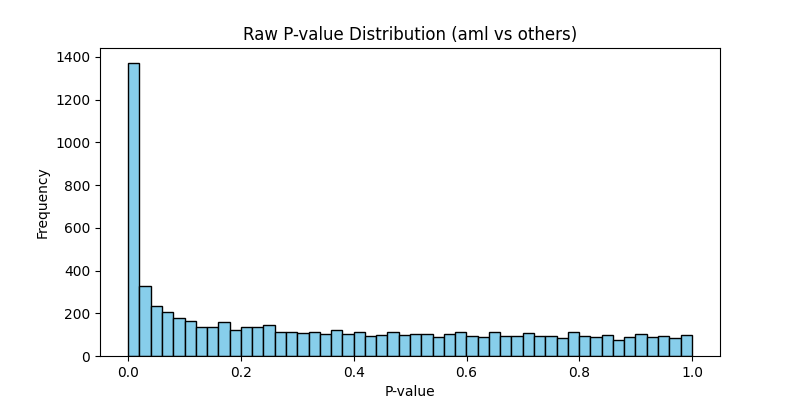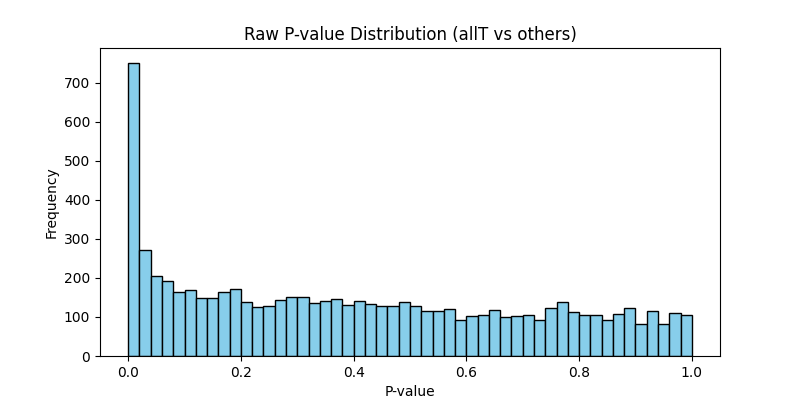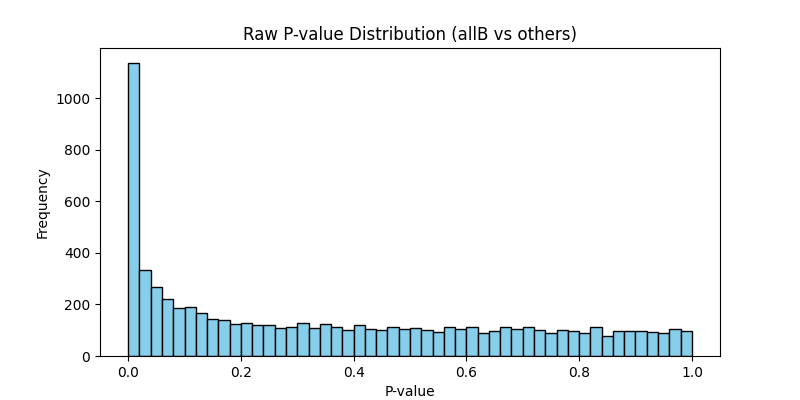

According to the three figures, tailed distributions can be observed in all cases, indicating that each group contains a large number of significant genes.

**3. p value distribution with BH correction**

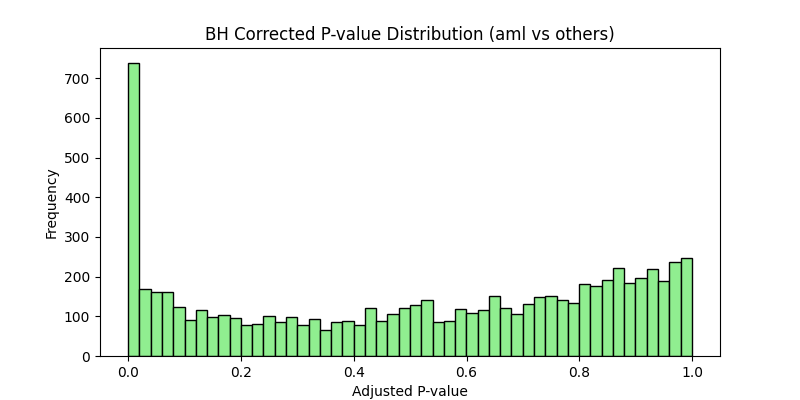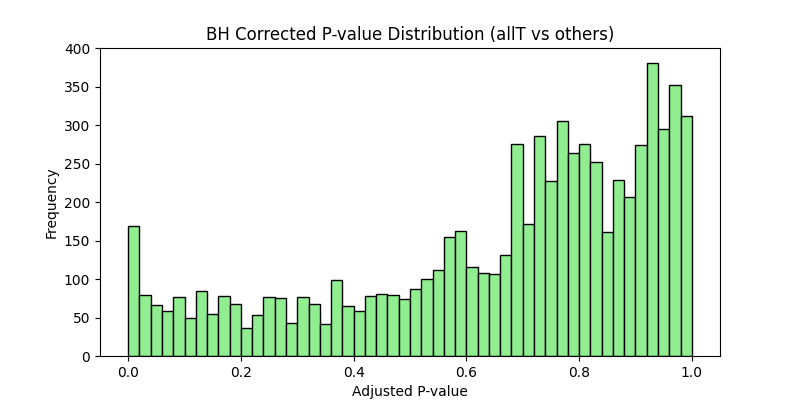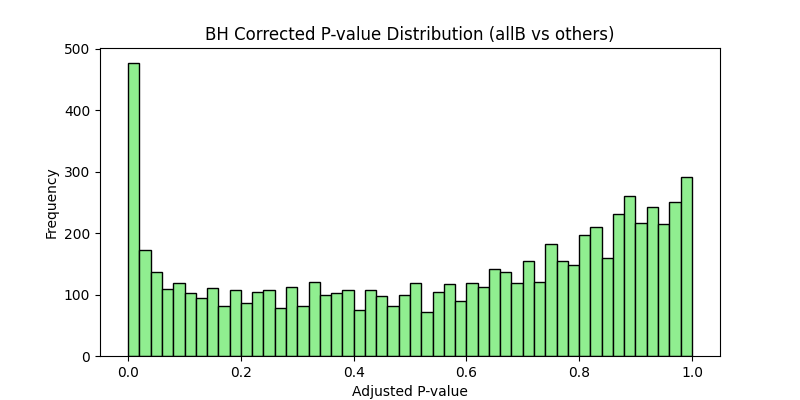

From the figures, it can be observed that after BH correction, both the comparisons "allB vs others" and "aml vs others" still exhibit clear peaks near zero. However, the overall distributions are flatter compared to the pre-correction results, with noticeable increases toward p-values near 1. This indicates that a substantial number of genes remain statistically significant after correction, reflecting genuine biological differences.

In contrast, in the comparison of "allT vs others," the number of significant genes significantly decreases after BH correction, and most genes do not exhibit real differences, indicating fewer significantly different genes in this group.









**4.BH threshold plot**

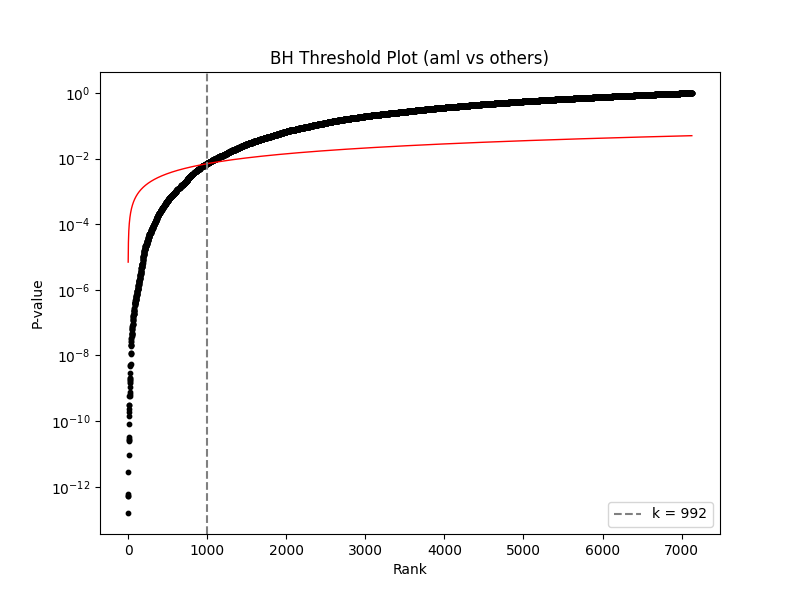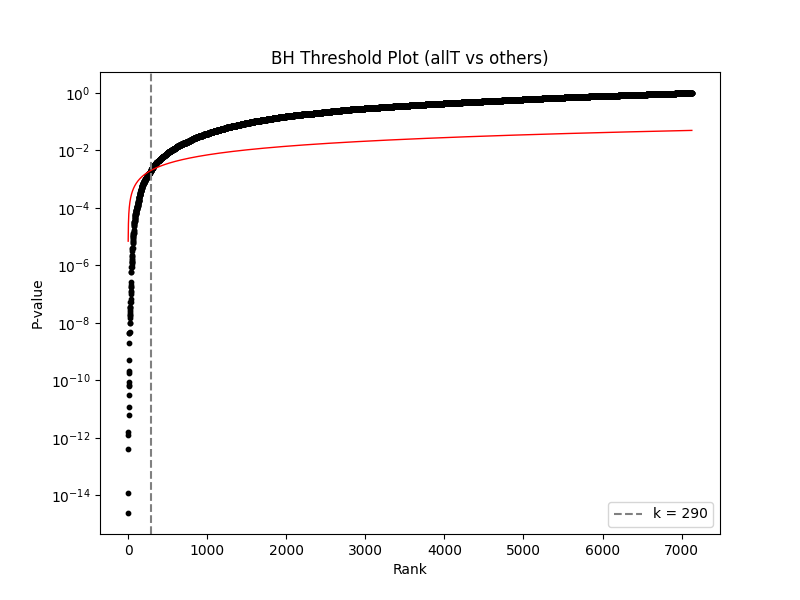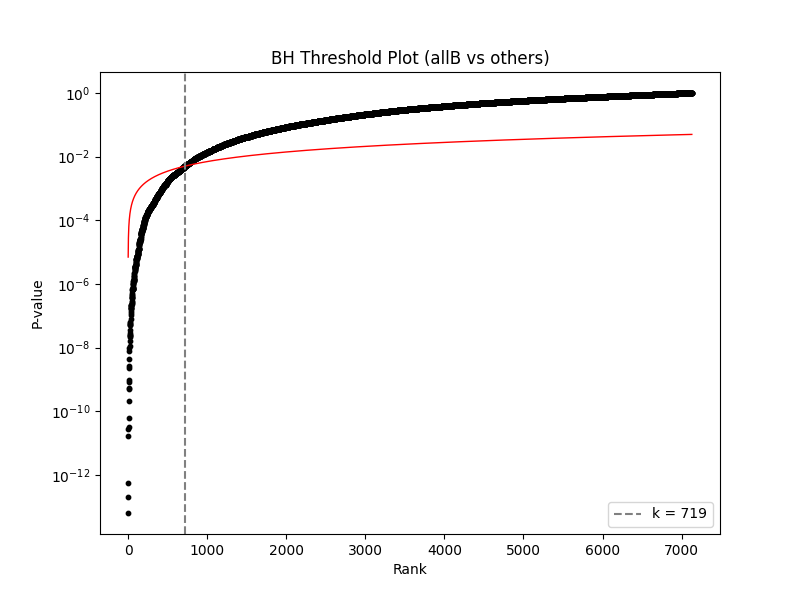

5. BH significant genes number and top 10 maker

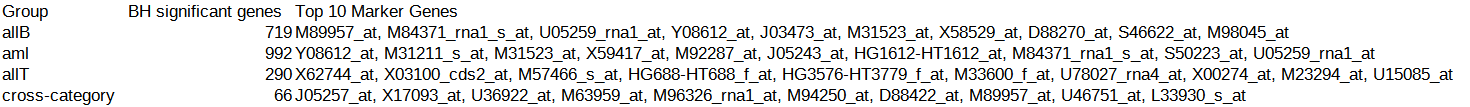

6. for all significant genes can be accessed: [specific significant genes in our github](https://github.com/Collin2210/Benjamini-Hochberg-Procedure/tree/main)

**Conclusion:**

Based 4,5,6,

*   For *allB vs other categories*: 719 significant genes were identified, indicating **notable expression differences** between the allB group and other groups, reflecting rich genetic characteristics
*   For *AML vs other categories*: Up to 992 significant genes were found, suggesting that AML (acute myeloid leukemia) exhibits **very distinct gene** expression differences compared to ALL subtypes.
*   For *allT vs other categories*: Only 290 sighnificant genes were found,suggesting **weaker expression differences or fewer specific gene-expression** patterns in the allT group compared to other groups.
*   For *Cross-category significance*: A total of 66 genes were found to be significantly expressed across all group comparisons, suggesting these genes may be involved in **common pathogenic mechanisms of leukemia**. However, further studies are required due to the lack of a normal control group.




